# Time Series Anomaly Detection with PyCaret

## Import Data Set

In [73]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [74]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.head()
#value

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [75]:
#create moving-averages
data['MA48'] = data['value'].rolling(48).mean() #하루
data['MA336'] = data['value'].rolling(336).mean() #일주일

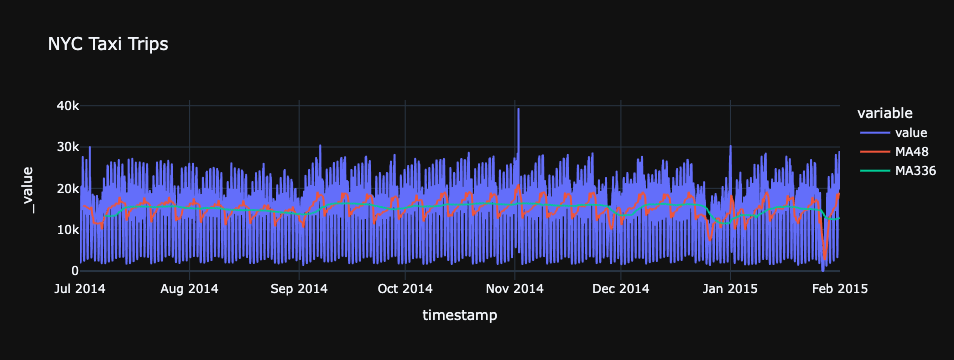

In [76]:
# plot 
import plotly.express as px
fig = px.line(data, x="timestamp", y=['value', 'MA48', 'MA336'], title='NYC Taxi Trips', template = 'plotly_dark')
fig.show()

## Data Preparation

In [77]:
data.head(5)

,timestamp,value,MA48,MA336
0,2014-07-01 00:00:00,10844,NaN,NaN
1,2014-07-01 00:30:00,8127,NaN,NaN
2,2014-07-01 01:00:00,6210,NaN,NaN
3,2014-07-01 01:30:00,4656,NaN,NaN
4,2014-07-01 02:00:00,3820,NaN,NaN


In [78]:
# drop moving-average columns
data.drop(['MA48', 'MA336'], axis=1, inplace=True)
# set timestamp to index
data.set_index('timestamp', drop=True, inplace=True)
# resample timeseries to hourly 
data = data.resample('d').sum()  #시간별로 합쳐서 새로운 sample 데이터 만들기
data

,value
timestamp,
2014-07-01,745967
2014-07-02,733640
2014-07-03,710142
2014-07-04,552565
2014-07-05,555470
...,...
2015-01-27,232058
2015-01-28,621483
2015-01-29,704935


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2014-07-01 to 2015-01-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   215 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [80]:
# creature features from date
data['day'] = [i.day for i in data.index]
data['day_name'] = [i.day_name() for i in data.index]
data['day_of_year'] = [i.dayofyear for i in data.index]
data['week_of_year'] = [i.weekofyear for i in data.index]
data['hour'] = [i.hour for i in data.index]
data['is_weekday'] = [i.isoweekday() for i in data.index]
data.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday
timestamp,,,,,,,
2014-07-01,745967,1,Tuesday,182,27,0,2
2014-07-02,733640,2,Wednesday,183,27,0,3
2014-07-03,710142,3,Thursday,184,27,0,4
2014-07-04,552565,4,Friday,185,27,0,5
2014-07-05,555470,5,Saturday,186,27,0,6


## Experiment Setup

In [81]:
# init setup
from pycaret.anomaly import *
s = setup(data, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(215, 7)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,3
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(215, 19)"
9,CPU Jobs,-1


## Model Training

In [46]:
# check list of available models
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [82]:
# train model
iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
#iforest_results.head()

In [83]:
#음수면 정상 양수면 anmaly
iforest_results[iforest_results['Anomaly'] == 0].describe()

,value,day,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
count,193.000000,193.000000,193.000000,193.000000,193.0,193.000000,193.0,193.000000
mean,737431.932642,15.461140,250.725389,36.544041,0.0,3.994819,0.0,-0.060331
std,77197.231078,8.496923,84.409297,12.026853,0.0,2.019430,0.0,0.024498
min,523184.000000,1.000000,5.000000,2.000000,0.0,1.000000,0.0,-0.102479
25%,694510.000000,8.000000,215.000000,31.000000,0.0,2.000000,0.0,-0.078120
50%,739760.000000,15.000000,263.000000,38.000000,0.0,4.000000,0.0,-0.064000
75%,779930.000000,22.000000,311.000000,45.000000,0.0,6.000000,0.0,-0.048510
max,986568.000000,31.000000,362.000000,52.000000,0.0,7.000000,0.0,-0.000486


In [84]:
iforest_results[iforest_results['Anomaly'] == 1].describe()

,value,day,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
count,22.000000,22.000000,22.000000,22.000000,22.0,22.000000,22.0,22.000000
mean,631606.954545,19.363636,110.454545,9.500000,0.0,4.045455,1.0,0.028022
std,152018.925138,11.429058,157.985451,17.363755,0.0,1.785584,0.0,0.022377
min,232058.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.0,0.000324
25%,586958.750000,7.250000,7.250000,1.000000,0.0,3.000000,1.0,0.013517
50%,673036.000000,25.500000,26.500000,3.000000,0.0,4.000000,1.0,0.025109
75%,718340.000000,28.750000,277.000000,5.000000,0.0,5.000000,1.0,0.039751
max,897719.000000,31.000000,365.000000,52.000000,0.0,7.000000,1.0,0.090219


In [85]:
# check anomalies
iforest_results[iforest_results['Anomaly'] == 1].head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
timestamp,,,,,,,,,
2014-12-25,379302,25,Thursday,359,52,0,4,1,0.037571
2014-12-26,499102,26,Friday,360,52,0,5,1,0.043881
2014-12-27,586604,27,Saturday,361,52,0,6,1,0.000838
2014-12-29,588023,29,Monday,363,1,0,1,1,0.023302
2014-12-30,655665,30,Tuesday,364,1,0,2,1,0.044095


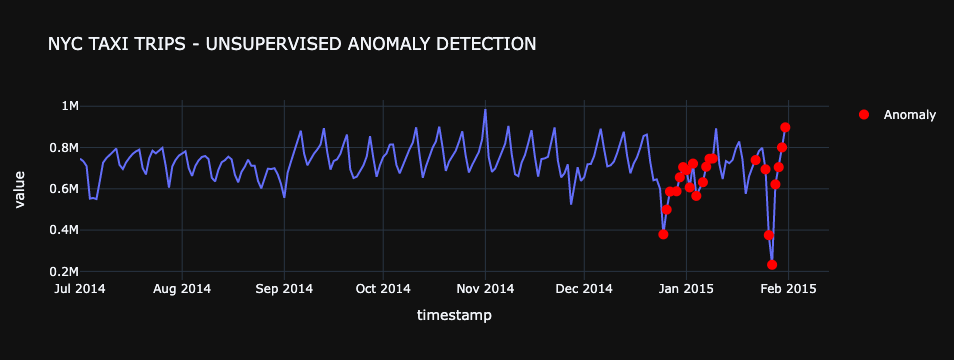

In [86]:
import plotly.graph_objects as go
# plot value on y-axis and date on x-axis
fig = px.line(iforest_results, x=iforest_results.index, y="value", title='NYC TAXI TRIPS - UNSUPERVISED ANOMALY DETECTION', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()